In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


In [0]:
%tensorflow_version 2.x
import os
import cv2
import glob
import time
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from emotenn import constants as ct, load_utils as lu, train_utils as tu, plot_utils as pu, gen_utils as gu

from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras import callbacks
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
from keras.regularizers import l2
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

!pip install keras_vggface
from keras_vggface.vggface import VGGFace

## Load all datasets

Train data consists of images from three datasets: FER2013, ExpW and JAFFE. 

Test and validation datasets are generated from FER2013 to get the valid comparison of the different networks.

In [0]:
start = time.time()

FER2013 = ct.GDriveFile('16xRMknw-dt13YjvvSPwtpSlYXsE73awF', os.path.join(ct.DATASETS_DIR, 'FER2013.zip'))
EXPW = ct.GDriveFile('1iKBcurf4zcJ2CNEOBB6BTfReTYz-ctmD', os.path.join(ct.DATASETS_DIR, 'EXPW.zip'))
JAFFE = ct.GDriveFile('1GQBTlVXsaKqtgrkTvuVIu9pF4ND2VKLC', os.path.join(ct.DATASETS_DIR, 'JAFFE.zip'))

train_dir = os.path.join(ct.UNPACKED_DIR, 'train')
valid_dir = os.path.join(ct.UNPACKED_DIR, 'valid')
test_dir = os.path.join(ct.UNPACKED_DIR, 'test')

valid_subset_size = 0.2
test_subset_size = 0.2

for directory in [train_dir, valid_dir, test_dir]:
    if os.path.exists(directory):
        os.remove(directory)
    for class_name in ct.CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        os.makedirs(class_dir)

for dataset in [FER2013, EXPW, JAFFE]:
    lu.download_file_from_google_drive(dataset, exist_ok=True)
    with zipfile.ZipFile(dataset.path, 'r') as archive:
        archive.extractall(train_dir)

for class_name in ct.CLASS_NAMES:
    fer_images = sorted(glob.glob(os.path.join(train_dir, class_name, 'fer2013_*.*')))
    valid_subset = int(len(fer_images) * valid_subset_size)
    test_subset = int(len(fer_images) * test_subset_size)

    for image in fer_images[:valid_subset]:
        os.rename(image, os.path.join(valid_dir, class_name, os.path.basename(image)))

    for image in fer_images[valid_subset:valid_subset+test_subset]:
        os.rename(image, os.path.join(test_dir, class_name, os.path.basename(image)))

end = time.time()
print(f'Elapsed: {end-start:.1f} seconds')

Elapsed: 236.6 seconds


## Train Resnet-50

In [0]:
def build_model():
    with tf.device('GPU:0'):
        vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        last_layer = vgg_notop.get_layer('avg_pool').output
        x = Flatten(name='flatten')(last_layer)
        x = Dense(4096, activation='relu', name='fc6')(x)
        x = Dense(1024, activation='relu', name='fc7')(x)
        for i in range(101):
            vgg_notop.layers[i].trainable = False

        out = Dense(7, activation='softmax', name='classifier')(x)
        custom_resnet = Model(vgg_notop.input, out)
        custom_resnet.compile(optimizer='sgd',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
        return custom_resnet

def get_callbacks(model_name):
    path = os.path.join(ct.CHECKPOINTS_DIR, model_name + '-{epoch:02d}-{val_accuracy:.2f}.h5')
    os.makedirs(ct.CHECKPOINTS_DIR, exist_ok=True)

    return [
        # callbacks.EarlyStopping(verbose=1, patience=10, monitor='val_accuracy', mode='max'),
        callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='max', epsilon=0.0001, cooldown=0, min_lr=0),
        callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')                 
    ]

In [0]:
batch_size = 128
data_gen = ImageDataGenerator()
train_data = data_gen.flow_from_directory(train_dir,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size)
valid_data = data_gen.flow_from_directory(valid_dir,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          shuffle=False)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 113545 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


In [0]:
epochs = 2
cb = get_callbacks('resnet-big-dataset')

model = build_model()
train_history = model.fit(x=train_data,
                          steps_per_epoch=train_data.samples // train_data.batch_size,
                          validation_data=valid_data,
                          validation_steps=valid_data.samples // valid_data.batch_size,
                          callbacks=cb,
                          epochs=epochs)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/2
887/887 [==============================] - 1723s 2s/step - loss: 0.9270 - accuracy: 0.6830 - val_loss: 0.4648 - val_accuracy: 0.5432

Epoch 00001: val_accuracy improved from -inf to 0.54325, saving model to /content/emotenn/results/checkpoints/resnet-big-dataset-01-0.54.h5
Epoch 2/2
887/887 [==============================] - 1713s 2s/step - loss: 0.7344 - accuracy: 0.7381 - val_loss: 0.3929 - val_accuracy: 0.5576

Epoch 00002: val_accuracy improved from 0.54325 to 0.55762, saving model to /content/emotenn/results/checkpoints/resnet-big-dataset-02-0.56.h5


In [0]:
train_history_p2 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=3,
                             initial_epoch=2)

Epoch 3/3
887/887 [==============================] - 1715s 2s/step - loss: 0.6153 - accuracy: 0.7800 - val_loss: 0.5667 - val_accuracy: 0.5889

Epoch 00003: val_accuracy improved from 0.55762 to 0.58887, saving model to /content/emotenn/results/checkpoints/resnet-big-dataset-03-0.59.h5


In [0]:
train_history_p3 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=4,
                             initial_epoch=3)

Epoch 4/4
887/887 [==============================] - 1717s 2s/step - loss: 0.4830 - accuracy: 0.8277 - val_loss: 0.5634 - val_accuracy: 0.5950

Epoch 00004: val_accuracy improved from 0.58887 to 0.59501, saving model to /content/emotenn/results/checkpoints/resnet-big-dataset-04-0.60.h5


In [0]:
train_history_p4 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=5,
                             initial_epoch=4)

Epoch 5/5
887/887 [==============================] - 1714s 2s/step - loss: 0.3428 - accuracy: 0.8797 - val_loss: 0.5058 - val_accuracy: 0.5537

Epoch 00005: val_accuracy did not improve from 0.59501


In [0]:
train_history_p5 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=6,
                             initial_epoch=5)

Epoch 6/6
887/887 [==============================] - 1718s 2s/step - loss: 0.2209 - accuracy: 0.9249 - val_loss: 1.2741 - val_accuracy: 0.5720

Epoch 00006: val_accuracy did not improve from 0.59501


In [0]:
train_history_p6 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=7,
                             initial_epoch=6)

Epoch 7/7
887/887 [==============================] - 1714s 2s/step - loss: 0.1291 - accuracy: 0.9597 - val_loss: 0.8674 - val_accuracy: 0.5684

Epoch 00007: val_accuracy did not improve from 0.59501


In [0]:
train_history_p7 = model.fit(x=train_data,
                             steps_per_epoch=train_data.samples // train_data.batch_size,
                             validation_data=valid_data,
                             validation_steps=valid_data.samples // valid_data.batch_size,
                             callbacks=cb,
                             epochs=8,
                             initial_epoch=7)

Epoch 8/8
887/887 [==============================] - 1715s 2s/step - loss: 0.0929 - accuracy: 0.9717 - val_loss: 1.2056 - val_accuracy: 0.5469

Epoch 00008: val_accuracy did not improve from 0.59501


## Evaluate the model

Test data consists of the FER2013 images.

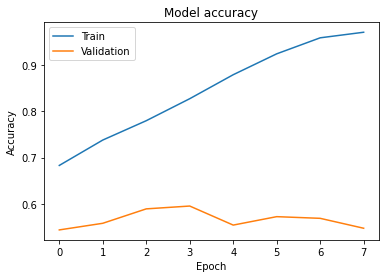

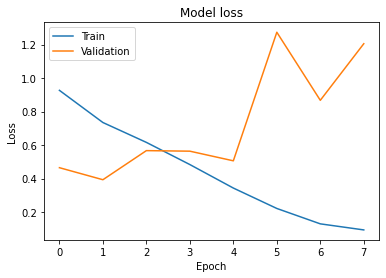

In [0]:
aggregated_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for history in [train_history, train_history_p2, train_history_p3, train_history_p4, train_history_p5, train_history_p6, train_history_p7]:
    for key in aggregated_history.keys():
        aggregated_history[key] += history.history[key]
pu.plot_model_history(aggregated_history)

In [0]:
test_data = data_gen.flow_from_directory(test_dir,
                                         classes=ct.CLASS_NAMES,
                                         target_size=(224, 224),
                                         batch_size=batch_size,
                                         shuffle=False)

Found 7174 images belonging to 7 classes.


56/56 [==============================] - 68s 1s/step
Dataset accuracy: 56.15%


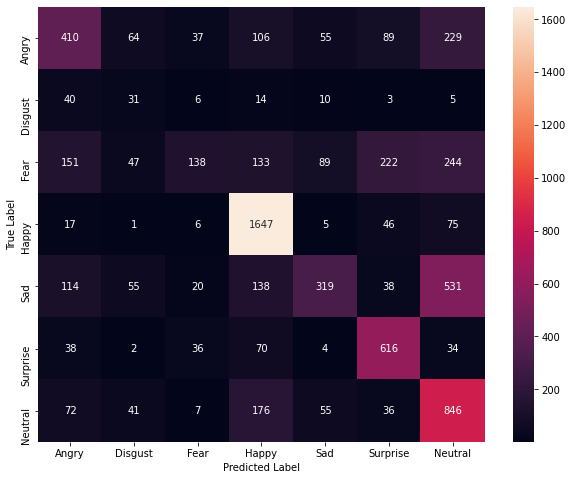

In [0]:
score = model.evaluate(x=test_data, steps=test_data.samples // test_data.batch_size)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))

predictions = model.predict(x=test_data, steps=test_data.samples // test_data.batch_size)
Y_pred = np.rint(predictions)
Y_true = test_data.classes[:len(Y_pred)]

from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true, np.argmax(Y_pred, axis=1)) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=ct.CLASS_NAMES, yticklabels=ct.CLASS_NAMES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [0]:
model.save('resnet-big-dataset-final.h5')